In [148]:
from bloqade import var, save, load
from bloqade.atom_arrangement import Chain
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from pathlib import Path
import json


In [149]:
experiments_dir = Path.cwd() / "experiments"
if not experiments_dir.is_dir():
    experiments_dir.mkdir()

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
result_dir = experiments_dir / timestamp
result_dir.mkdir()

print(f"Results will be stored in: {result_dir}")

Results will be stored in: c:\Users\agpri\OneDrive\Documents\GitHub\yquantum24\experiments\2024-04-14_00-55-06


In [150]:
# Set basic parameters here
n_atoms = 10
lattice_spacing = 6
shots = 100

# Parameters for times to take measurements
# np.arange(start, end, step)   

prep_times = np.arange(0.2, 2.2, 0.1)
scar_times = np.arange(2.2, 3.99, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

run_time = var("run_time")

In [151]:
quantum_scar_program = (
    Chain(n_atoms, lattice_spacing=lattice_spacing)
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        [0.3, 1.6, 0.3], [-18.8, -18.8, 16.3, 16.3]
    )
    .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0, 15.7, 15.7, 0.0])
    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

In [152]:
quantum_scar_program = (
    Chain(n_atoms, lattice_spacing=lattice_spacing)
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        [0.3, 1.6, 0.3], [-18.8, -18.8, 16.3, 16.3]
    )
    .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0, 15.7, 15.7, 0.0])
    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

In [153]:
batch = quantum_scar_program.batch_assign(run_time=run_times)

In [154]:
# ## Run on Emulator and Hardware
# We will run the experiment on the emulator and hardware, saving the results to disk
# so that we can plot them later. for more details on where these lines of code come
# from, see the first few tutorials.

emulator_filename = str(result_dir / "emulator_results.json")

if not os.path.isfile(emulator_filename):
    emu_batch = batch.bloqade.python().run(shots, interaction_picture=True)
    save(emu_batch, emulator_filename)


In [155]:
# %% [markdown]
# ## Plotting the results
# The quantity we are interested in is the probability of the atoms being in the Z2
# state. We can get this by looking at the counts of the Z2 state in the report
# Below we define a function that will get the probability of the Z2 state for each
# time step in the experiment.

emu_batch = load(emulator_filename)

In [156]:
# Generate Z2 and Z2 prime states

def generate_state_string(n_bits, first_bit_state: str):
    """ Generates a string of 1s and 0s indicating the state of n alternating bits.
        The first bit is the first bit of the string.
    """
    state = first_bit_state
    for i in range(n_bits - 1):
        if state[-1] == "0":
            state += "1"
        else:
            state += "0"
    return state


Z2_STATE = generate_state_string(n_atoms, "0")
Z2_PRIME_STATE = generate_state_string(n_atoms, "1")

print("Z2 State: ", Z2_STATE)
print("Z2 Prime State: ", Z2_PRIME_STATE)




Z2 State:  0101010101
Z2 Prime State:  1010101010


In [157]:
def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get(Z2_STATE, 0) / sum(list(count.values())) # origional state 01010101010
        z2_probabilities.append(z2_probability)

    return z2_probabilities

def get_z2_prime(report):
    z2_primes = []

    for count in report.counts():
        z2_prime = count.get(Z2_PRIME_STATE, 0) / sum(list(count.values())) # inverted state 10101010101
        z2_primes.append(z2_prime)

    return z2_primes

In [158]:
emu_report = emu_batch.report()

In [159]:
emu_run_times = emu_report.list_param("run_time")
emu_z2_prob = get_z2_probabilities(emu_report)
emu_z2_prime = get_z2_prime(emu_report)

In [160]:
# Save parameters of experiments to file
experiment_parameters = {
    "shape": "chain",
    "n_atoms": n_atoms,
    "lattice_spacing": lattice_spacing,
    "shots": shots,
}

parameters_file_path = result_dir / "parameters.json"
with open(parameters_file_path, "w") as json_file:
    json.dump(experiment_parameters, json_file)

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\agpri\AppData\Local\Temp\ipykernel_13304\3392032865.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


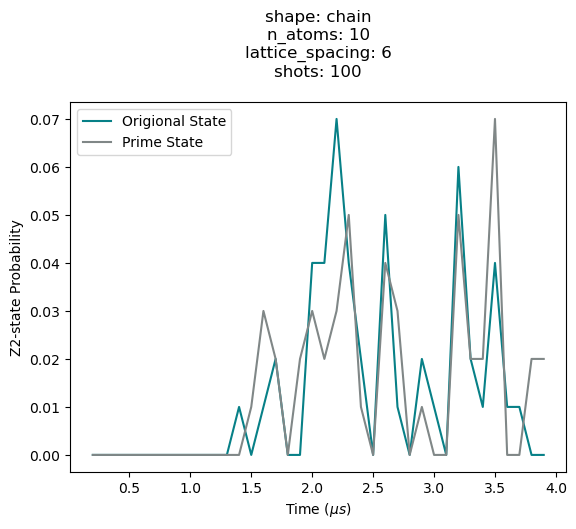

In [161]:
plt.plot(emu_run_times, emu_z2_prob, label="Original State", color="#078087")
plt.plot(emu_run_times, emu_z2_prime, label="Prime State", color="#808787")
plt.legend()
title = ""
for key, value in experiment_parameters.items():
    title += f"{key}: {value}\n"
plt.title(title)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Z2-state Probability")

plt.savefig(result_dir / "plot.png")
plt.show()
